In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from dataset import BackendJsonDataset, BackendDataset

from tqdm import tqdm

In [2]:
DATA_PATH = "./data_revised.json"

raw_data = BackendJsonDataset(DATA_PATH)
game_ids = raw_data.get_game_ids()
game_ids

['2195', '1773', '1802', '2516']

In [3]:
data = raw_data.get_all_dfs()
data.keys()

dict_keys(['X', 't', 'y', 'errors'])

In [4]:
len(data["X"])

573

In [5]:
len(data["errors"])
# error means no login records

1865

In [6]:
dataset = BackendDataset(data)

In [7]:
dataset[0]
# X, t, y

(tensor([[ 0.7818,  0.6235,  0.0000,  1.0000,  0.0000],
         [ 0.7818,  0.6235,  0.2588,  0.9659,  0.0000],
         [ 0.7818,  0.6235,  0.5000,  0.8660,  0.0000],
         ...,
         [ 0.0000,  1.0000, -0.7071,  0.7071,  0.0000],
         [ 0.0000,  1.0000, -0.5000,  0.8660,  0.0000],
         [ 0.0000,  1.0000, -0.2588,  0.9659,  0.0000]]),
 tensor(1.),
 tensor(0.))

In [8]:
for v in dataset[0]:
    print(v.shape)

torch.Size([336, 5])
torch.Size([])
torch.Size([])


In [9]:
train_dl = DataLoader(dataset, batch_size=16, shuffle=True)

In [10]:
from model import UpliftWrapperForRNN, DirectUpliftLoss, RNNEmbedding

In [11]:
OUT_FEATURES = 16

rnn = RNNEmbedding(
    in_features=5, 
    hidden_size=16, 
    out_features=OUT_FEATURES, 
    num_layers=1, 
    dropout=0.2, 
    bidirectional=False
)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [12]:
model = UpliftWrapperForRNN(rnn, OUT_FEATURES)

In [13]:
batch = next(iter(train_dl))
for v in batch:
    print(v.shape)

torch.Size([16, 336, 5])
torch.Size([16])
torch.Size([16])


In [14]:
x = batch[0]
t = batch[1]

out = model(x, t)

In [15]:
out["uplift"]

tensor([-0.0238, -0.0238, -0.0255, -0.0236, -0.0230, -0.0260, -0.0238, -0.0237,
        -0.0230, -0.0238, -0.0258, -0.0238, -0.0255, -0.0237, -0.0238, -0.0255],
       grad_fn=<SubBackward0>)

In [16]:
out["pred"]

tensor([0.5114, 0.5114, 0.5071, 0.4800, 0.5074, 0.5073, 0.5114, 0.4792, 0.5074,
        0.5114, 0.5065, 0.5114, 0.5071, 0.4792, 0.5114, 0.5071],
       grad_fn=<SWhereBackward>)

In [17]:
out["uplift"].shape, out["pred"].shape

(torch.Size([16]), torch.Size([16]))

In [18]:
criterion = DirectUpliftLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
NUM_EPOCHS = 30
CUTOFF = 0.2
# cutoff value must depend on the proportion of Y = 1

train_losses = []
train_accuracies = []

for epoch in range(NUM_EPOCHS):
    print(f"epoch: {epoch}")

    train_answ = []
    train_pred = []

    model.train()

    for X, t, y in train_dl:
        optimizer.zero_grad()
        train_answ.extend(y.numpy().tolist())
        
        out = model(X, t)
        loss = criterion(out, t, y)
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        # needs to carefully set cutoff!!!
        pred = np.where(out["pred"].detach().numpy() > CUTOFF, 1, 0)
        train_pred.extend(pred.tolist())

    train_answ = np.array(train_answ)
    train_pred = np.array(train_pred)

    train_accuracies.append(np.sum(train_answ == train_pred)/len(train_answ))
    print(f"train accuracy: {train_accuracies[-1]}, train f1: {f1_score(train_answ, train_pred)}")

    print()

epoch: 0
train accuracy: 0.193717277486911, train f1: 0.32456140350877194

epoch: 1
train accuracy: 0.2774869109947644, train f1: 0.3053691275167786

epoch: 2
train accuracy: 0.5462478184991274, train f1: 0.2737430167597765

epoch: 3
train accuracy: 0.6527050610820244, train f1: 0.27636363636363637

epoch: 4
train accuracy: 0.7556719022687609, train f1: 0.27835051546391754

epoch: 5
train accuracy: 0.5794066317626527, train f1: 0.2932551319648094

epoch: 6
train accuracy: 0.7905759162303665, train f1: 0.28571428571428575

epoch: 7
train accuracy: 0.518324607329843, train f1: 0.29949238578680204

epoch: 8
train accuracy: 0.7137870855148342, train f1: 0.2545454545454545

epoch: 9
train accuracy: 0.612565445026178, train f1: 0.32317073170731714

epoch: 10
train accuracy: 0.6719022687609075, train f1: 0.2713178294573644

epoch: 11
train accuracy: 0.6614310645724258, train f1: 0.3120567375886525

epoch: 12
train accuracy: 0.6020942408376964, train f1: 0.3254437869822485

epoch: 13
train acc

In [32]:
# Predicting uplift scores
y_true = []
t_true = []
y_pred = []
y_prob = []
u_pred = []

model.eval()

for X, t, y in tqdm(train_dl):
    out = model(X, t)
    pred = np.where(out["pred"].detach().numpy() > 0.5, 1, 0)
    
    y_true.extend(y.tolist())
    t_true.extend(t.tolist())
    y_prob.extend(out["pred"].detach().numpy().tolist())
    y_pred.extend(pred.tolist())
    u_pred.extend(out["uplift"].tolist())

100%|██████████| 36/36 [00:03<00:00, 11.85it/s]


In [21]:
sum(y_true)/len(y_true)

0.193717277486911

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

array([[459,   3],
       [ 69,  42]])

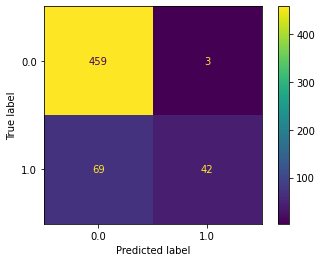

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

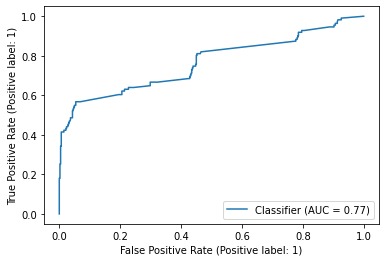

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true, y_prob)
plt.show()

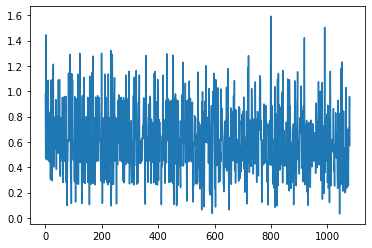

In [25]:
plt.plot(train_losses)

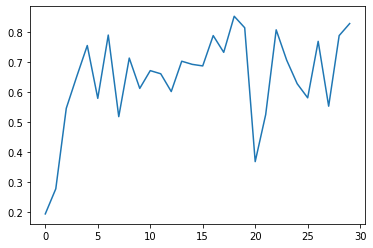

In [26]:
plt.plot(train_accuracies)

(array([500.,  19.,   2.,   3.,   4.,  13.,  18.,   4.,  10.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

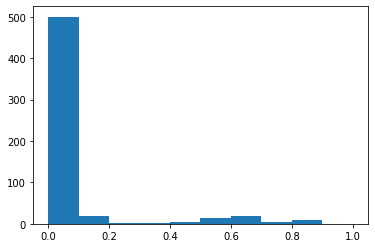

In [30]:
plt.hist(y_prob, bins=np.arange(0.0, 1.1, 0.1))

(array([ 20.,  14.,   2.,   1.,   1.,   0.,   0.,   2., 373., 160.]),
 array([-0.3519524 , -0.31273814, -0.27352387, -0.2343096 , -0.19509533,
        -0.15588106, -0.11666679, -0.07745253, -0.03823826,  0.00097601,
         0.04019028]),
 <BarContainer object of 10 artists>)

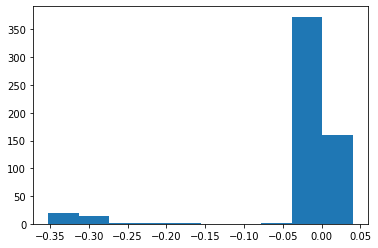

In [31]:
plt.hist(u_pred)

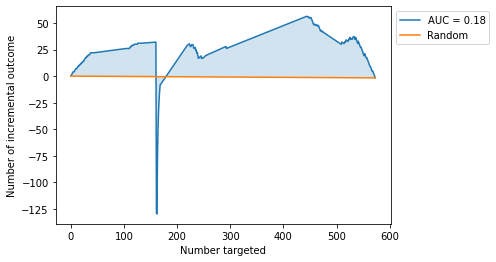

In [47]:
from sklift.viz import plot_uplift_curve, plot_qini_curve

plot_uplift_curve(y_true, u_pred, t_true)

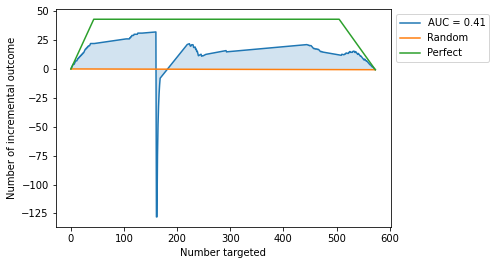

In [45]:
plot_qini_curve(y_true, u_pred, t_true)

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = -0.0029'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

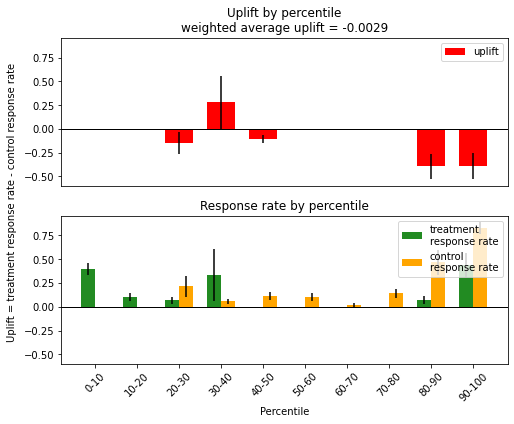

In [46]:
from sklift.viz import plot_uplift_by_percentile

plot_uplift_by_percentile(y_true, u_pred, t_true, kind='bar')